In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib import colors
from scipy import stats

# --------------- IMPORTING THE DATA --------------- #

# Evacuation Data
evacdata = pd.read_csv('./outputs_new/warn_period/gy-evac warn_period-table.csv', skiprows=6).sort_values(by=['warning-interval-time-mins', 'ticks']).reset_index(drop=True)
# renaming the column to something that isn't cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']

# Journey Time Data
jm_files = glob.glob('./outputs_new/warn_period/jm*.csv')
journey_metrics_list = [pd.read_csv(file) for file in jm_files]
# Extract tick number from file names and add as a column to each dataframe
for i, file in enumerate(jm_files):
    tick_number = float(file.split('/')[-1].split('.')[-2].split('_')[-1][8:])
    journey_metrics_list[i]['warning_interval_time_mins'] =tick_number
# Concatenate the dataframes
journey_metrics = pd.concat(journey_metrics_list, ignore_index=True).sort_values(by=['warning_interval_time_mins', 'start_tick']).reset_index(drop=True)
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3 # 0.3 minutes per tick

# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']

# calculate the mean normalised journey time every 30 minutes for each run
# Bin the start_tick at intervals of 120 (corresponding to 30 minutes)
journey_metrics['start_time_bin'] = pd.cut(journey_metrics['start_time_minutes'], bins=np.arange(-15, journey_metrics['start_tick'].max() + 45, 30))
# Calculate the mean normalised journey time for each bin
mean_normalised_journey_time_per_bin = journey_metrics.groupby('start_time_bin')['normalised_journey_time'].mean().reset_index()
# Calculate the mean normalised journey time for each bin for each run
mean_normalised_journey_time_per_bin_per_run = journey_metrics.groupby(['warning_interval_time_mins', 'start_time_bin'])['normalised_journey_time'].mean().reset_index()

In [6]:
evacdata.head()

,run_number,terminate_evac_distance_km,initial_people,max_walking_distance_km,warning_interval_time_mins,evacuation_probability,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,get_avg_no_people_per_car,time_minutes
0,1,0.3,15000,0.3,30,0.3,0.3,0.06,0,0,0,0,0,0,0,0.000000,0.0
1,1,0.3,15000,0.3,30,0.3,0.3,0.06,1,1,1228,0,4467,7,4467,3.637622,0.3
2,1,0.3,15000,0.3,30,0.3,0.3,0.06,2,2,1224,0,4454,20,4454,3.638889,0.6
3,1,0.3,15000,0.3,30,0.3,0.3,0.06,3,3,1222,0,4448,26,4448,3.639935,0.9
4,1,0.3,15000,0.3,30,0.3,0.3,0.06,4,4,1218,0,4438,36,4438,3.643678,1.2


In [37]:
journey_metrics.warning_interval_time_mins.unique()

array([ 30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.])

In [7]:
journey_metrics.head()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,warning_interval_time_mins,start_time_minutes,normalised_journey_time,start_time_bin
0,2685,5,0.8500,0.25,0,0,0.0,0.0,0.294118,"(-15, 15]"
1,12567,5,0.8500,0.75,0,2,0.0,0.0,0.882353,"(-15, 15]"
2,26063,5,0.9350,0.75,0,2,0.0,0.0,0.802139,"(-15, 15]"
3,17718,1,0.9350,0.75,0,2,0.0,0.0,0.802139,"(-15, 15]"
4,2036,5,0.9375,1.00,0,3,0.0,0.0,1.066667,"(-15, 15]"


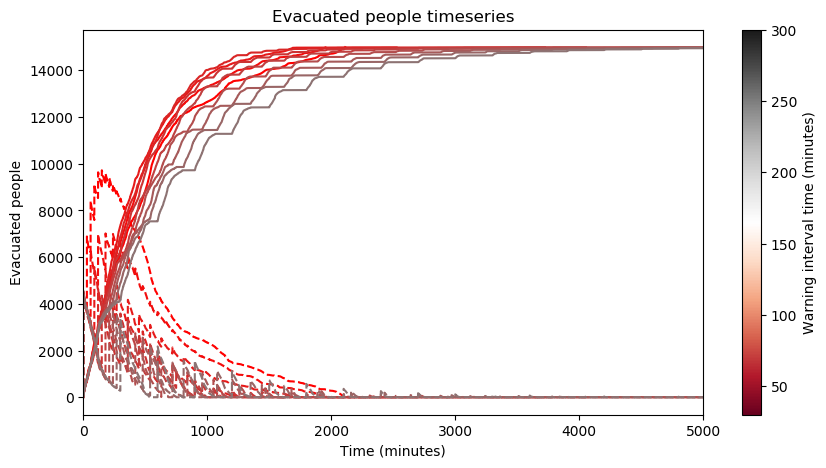

In [15]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(colors.to_rgb(c1))
    c2=np.array(colors.to_rgb(c2))
    return colors.to_hex((1-mix)*c1 + mix*c2)

c1='red' 
c2='gray'
n = len(list(evacdata['warning_interval_time_mins'].unique()))

# Plot each run
for i, ticktime in enumerate(evacdata['warning_interval_time_mins'].unique()):
    run_data = evacdata[evacdata['warning_interval_time_mins'] == ticktime]
    plt.plot(run_data["time_minutes"], run_data['get_no_evacuated'], color=colorFader(c1,c2,i/n))
    plt.plot(run_data["time_minutes"], run_data['get_no_evacuating'], linestyle='--', color=ax.get_lines()[-1].get_color())

#plt.colorbar(label = 'Warning interval time (minutes)')
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdGy, norm=plt.Normalize(vmin=evacdata['warning_interval_time_mins'].min(), vmax=evacdata['warning_interval_time_mins'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Warning interval time (minutes)')

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_title('Evacuated people timeseries')
ax.set_ylabel('Evacuated people')
ax.set_xlabel('Time (minutes)')
ax.set_xlim(0, 5000)

plt.show()

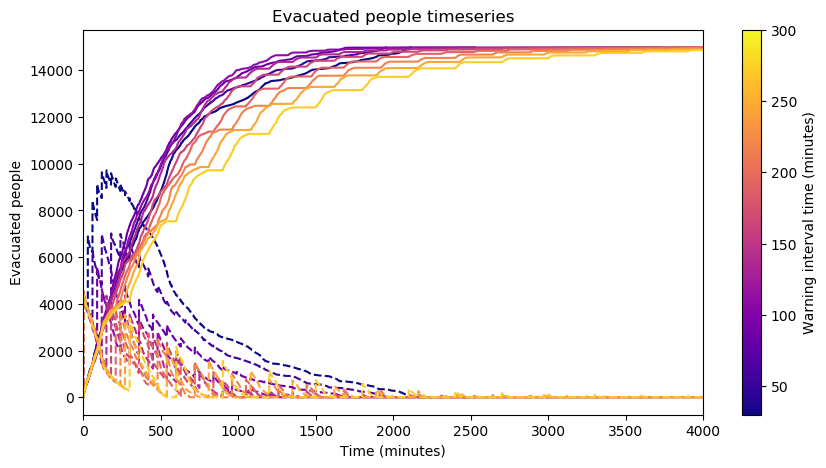

In [45]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(colors.to_rgb(c1))
    c2=np.array(colors.to_rgb(c2))
    return colors.to_hex((1-mix)*c1 + mix*c2)

c1='red' 
c2='gray'
n = len(list(evacdata['warning_interval_time_mins'].unique()))

# Plot each run
for i, ticktime in enumerate(evacdata['warning_interval_time_mins'].unique()):
    run_data = evacdata[evacdata['warning_interval_time_mins'] == ticktime]
    color = plt.cm.plasma(i / n)  # Use the jet colormap
    plt.plot(run_data["time_minutes"], run_data['get_no_evacuated'], color=color)
    plt.plot(run_data["time_minutes"], run_data['get_no_evacuating'], linestyle='--', color=color)

# Update colorbar to use the jet colormap
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=evacdata['warning_interval_time_mins'].min(), vmax=evacdata['warning_interval_time_mins'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Warning interval time (minutes)')

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_title('Evacuated people timeseries')
ax.set_ylabel('Evacuated people')
ax.set_xlabel('Time (minutes)')
ax.set_xlim(0, 4000)

plt.show()

^^ Evacuated people (solid lines) and evacuating people (dashed lines) over time. The color indicates the tick time in minutes and varies from red (0.05, the lowest value) to grey (1.0, the highest value) at intervals of 0.05.

In [36]:
journey_metrics.groupby('tick_time_in_mins')['normalised_journey_time'].mean()

tick_time_in_mins
0.25    67.175778
0.35    72.200806
0.45    73.567120
0.55    73.415599
0.65    74.510643
0.75    74.850415
0.85    75.555314
0.95    76.483334
Name: normalised_journey_time, dtype: float64

   warning_interval_time_mins  get_no_evacuated
0                          30              7174
1                          60              7667
2                          90              8279
3                         120              7925
4                         150              7373
5                         180              6560
6                         210              6375
7                         240              6272
8                         270              5959
9                         300              5292
mean    6887.600000
std      948.365635
max     8279.000000
min     5292.000000
skew      -0.115982
Name: get_no_evacuated, dtype: float64


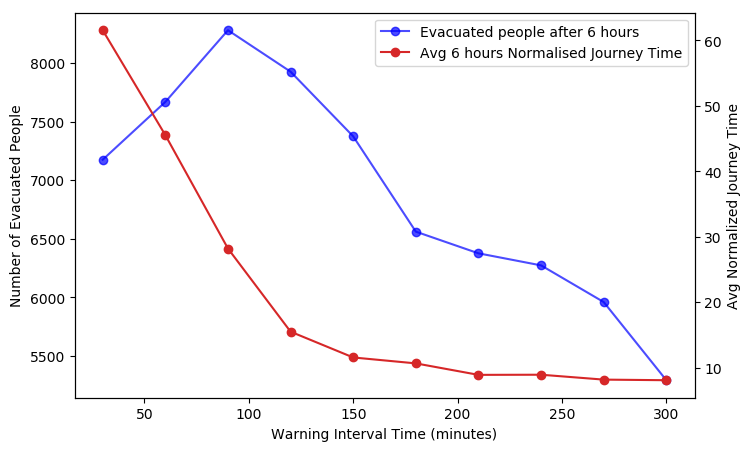

In [40]:
# get number of people evacuated after 6 hours
evacuated_at_6hours = evacdata[evacdata['time_minutes'] == 360].groupby('warning_interval_time_mins')['get_no_evacuated'].sum().reset_index()
print(evacuated_at_6hours)
# get the average normalised journey time over 6 hours
av_norm_journey_time = journey_metrics.groupby('warning_interval_time_mins')['normalised_journey_time'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
# ax.hist(evacuated_at_6hours['get_no_evacuated'], bins=10, density=True, alpha=0.6, color='g')
ax.plot(evacuated_at_6hours['warning_interval_time_mins'], evacuated_at_6hours['get_no_evacuated'], marker='o', color='b', alpha=0.7, label='Evacuated people after 6 hours')
ax.set_ylabel('Number of Evacuated People')
ax.set_xlabel('Warning Interval Time (minutes)')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Avg Normalized Journey Time')  # we already handled the x-label with ax1
ax2.plot(av_norm_journey_time, color='tab:red', marker='o', label='Avg 6 hours Normalised Journey Time')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

evacuated_stats = evacuated_at_6hours['get_no_evacuated'].agg(['mean', 'std', 'max', 'min'])
evacuated_stats['skew'] = stats.skew(evacuated_at_6hours['get_no_evacuated'])
print(evacuated_stats)

In [29]:
journey_metrics['warning_interval_time_mins'].unique()

array([12., 15., 18., 21., 24., 27., 30., 60., 90.])

In [25]:
print(f"max evac tick: {evacdata.warning_interval_time_mins.max()}\nmax jm tick: {journey_metrics.warning_interval_time_mins.max()}")

max evac tick: 300
max jm tick: 80.0


### INTERPRETATION

- the results change significantly with increasing tick time
- the number of people evacuated after 6 hours is decreases rapidly when tick time > 0.15
- the average normalised journey time increases rapidly after tick time > 0.25
- after this the change levels off and they increase (decrease) more gradually for number of people evacuated after 6 hours (6 hour average normalised journey time). 